In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [25]:
import os
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import glob

row = 8
def prep_data(path):
  data = []
  labels = []
  filenames = [img for img in glob.glob(path)]
  for name in tqdm(filenames):
      df = pd.read_csv(name, header=None, error_bad_lines=False)
      values = df.values[row - 1]
      data.append(values.tolist())
      split = name.split(os.sep)[-2]
      if split == 'control':
        labels.append(0)
      else:
        labels.append(1)

  data = np.asarray(data)
  labels = np.asarray(labels)
  return data,labels

In [4]:
train_x, train_y = prep_data('/content/drive/My Drive/datasets/N_dataset/train/*/*')

100%|██████████| 143/143 [07:16<00:00,  3.06s/it]


In [5]:
val_x, val_y = prep_data('/content/drive/My Drive/datasets/N_dataset/val/*/*')

100%|██████████| 55/55 [02:54<00:00,  3.17s/it]


In [6]:
test_x, test_y = prep_data('/content/drive/My Drive/datasets/N_dataset/test/*/*')

100%|██████████| 23/23 [01:15<00:00,  3.30s/it]


In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [110]:
print('Pad sequences (samples x time)')
maxlen = 1000
train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
val_x = sequence.pad_sequences(val_x, maxlen=maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=maxlen)

Pad sequences (samples x time)


In [111]:
model = Sequential()

batch_size = 32
embedding_dims = 5
filters = 80
kernel_size = 3
hidden_dims = 300
max_features = 8000

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
train_x.shape

(143, 1000)

In [113]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 5)           40000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000, 5)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 998, 80)           1280      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               24300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 300)              

In [114]:
slug = 'gazar_july_13_N'
epochs = 1000

In [115]:
pathModelSave = '/content/drive/My Drive/saveModels/epi_eeg_conv1D'+'_nigiria_'+str(embedding_dims)+'_'+str(filters)+'_'+str(batch_size)+'_'+str(epochs)+'_'+slug+'_.hdf5'
pathToSaveCSV = '/content/drive/My Drive/saveModels/csv/epi_eeg_conv1D'+'_nigiria_'+str(embedding_dims)+'_'+str(filters)+'_'+str(batch_size)+'_'+str(epochs)+'_'+slug+'_.csv'

In [116]:
import time
from keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint = ModelCheckpoint(pathModelSave, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')

tic = time.clock()
history = model.fit(
          train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [checkpoint, csv_logger],
          validation_data=(val_x, val_y))
toc = time.clock()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143 samples, validate on 55 samples
Epoch 1/1000
143/143 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5385 - val_loss: 0.6842 - val_accuracy: 0.5818

Epoch 00001: val_accuracy improved from -inf to 0.58182, saving model to /content/drive/My Drive/saveModels/epi_eeg_conv1D_nigiria_5_80_32_1000_gazar_july_13_.hdf5
Epoch 2/1000
143/143 [==============================] - 0s 353us/step - loss: 0.6839 - accuracy: 0.5804 - val_loss: 0.6815 - val_accuracy: 0.5818

Epoch 00002: val_accuracy did not improve from 0.58182
Epoch 3/1000
143/143 [==============================] - 0s 358us/step - loss: 0.6786 - accuracy: 0.5804 - val_loss: 0.6808 - val_accuracy: 0.5818

Epoch 00003: val_accuracy did not improve from 0.58182
Epoch 4/1000
143/143 [==============================] - 0s 339us/step - loss: 0.6740 - accuracy: 0.5804 - val_loss: 0.6806 - val_accuracy: 0.5818

Epoch 00004: val_accuracy did not improve from 0.58182
Epoch 5/1000
143/143 [==================

In [117]:
time = (toc-tic)/60
print("Total training time is: ", time)

Total training time is:  1.0372131166666672


In [118]:
_, acc = model.evaluate(val_x, val_y, verbose=0)
print('validation acc> %.3f' % (acc* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

validation acc> 40.000 %, tt: 1.0372131166666672 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 8


In [119]:
from keras.models import load_model
model_new = load_model(pathModelSave)

_train, acc_train = model_new.evaluate(train_x, train_y, verbose=0)
print('training acc> %.3f' % (acc_train* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

_val, acc_val = model_new.evaluate(val_x, val_y, verbose=0)
print('val..... acc> %.3f' % (acc_val* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

_test, acc_test = model_new.evaluate(test_x, test_y, verbose=0)
print('testing. acc> %.3f' % (acc_test* 100.0), '%, tt:', time,', ml:',maxlen,', bs:',batch_size,', e_d:',embedding_dims,
      ', f:',filters,', k_s:',kernel_size,', h_d:',hidden_dims,', epo:',epochs,', m_f:',max_features,', of row number:',row)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


training acc> 100.000 %, tt: 1.0372131166666672 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 8
val..... acc> 63.636 %, tt: 1.0372131166666672 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 8
testing. acc> 47.826 %, tt: 1.0372131166666672 , ml: 1000 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 1000 , m_f: 8000 , of row number: 8


In [120]:
# training acc> 100.000 %, tt: 0.45934235 , ml: 400 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 500 , m_f: 8000 , of row number: 8
# val..... acc> 65.455 %, tt: 0.45934235 , ml: 400 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 500 , m_f: 8000 , of row number: 8
# testing. acc> 52.174 %, tt: 0.45934235 , ml: 400 , bs: 32 , e_d: 5 , f: 80 , k_s: 3 , h_d: 300 , epo: 500 , m_f: 8000 , of row number: 8

#------------------

In [121]:
def convert_string_label(intLabel):
  Y = []
  length = len(intLabel)
  for i in range(length):
    if intLabel[i] == 0:
      Y.append("Control")
    elif intLabel[i] == 1:
      Y.append("Epilipsy")
  return Y

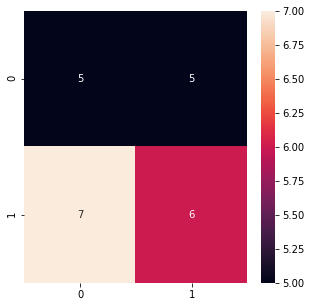

In [122]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_prediction = model_new.predict(test_x)
Y_pred_classes = []
for i in Y_prediction:
  if i[0] < 0.5:
    Y_pred_classes.append(0)
  else:
    Y_pred_classes.append(1)

Y_pred_classes = np.asarray(Y_pred_classes)
confusion_mtx = confusion_matrix(test_y, Y_pred_classes)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

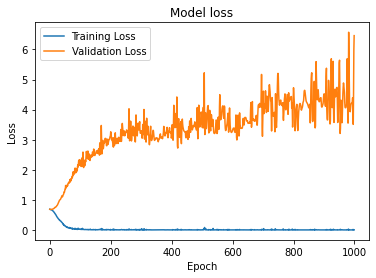

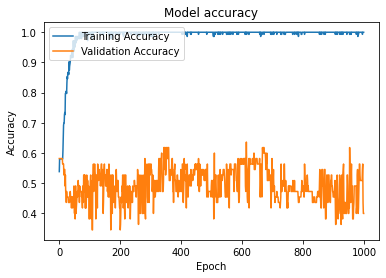

In [123]:
# author Manoj kaushik
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [124]:
# testing accuracies
import time
import os
import pandas as pd
import numpy as np
import sys
from keras.models import load_model
model = load_model(pathModelSave)

def predict_fun(filename, type, row):
  list = os.listdir(filename)
  list.sort()
  tic = time.clock()
  count_control = 0
  count = 0
  for name in list:
      count += 1
      file = os.path.join(filename, name)
      df = pd.read_csv(file, header = None, error_bad_lines = False)
      values = df.values[row - 1]
      data = []
      data.append(values.tolist())
      data = np.asarray(data)
      values = sequence.pad_sequences(data, maxlen = maxlen)
      p = model.predict(values)[0][0]
      if p < 0.5:
        count_control += 1
      #   print(count, '. ', name, ": Control predicted")
      # else :
      #   print(count, '. ', name, ": Epilipsy Pridicted")
  toc = time.clock()
  total_ele = len(list)
  print('total files of ' + str(type)+' are :', count, ' control predicted:', count_control, ' epilipsy predicted:', count - count_control, '| row',row)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [125]:
# total files of control are : 93  control predicted: 91  epilipsy predicted: 2 | row 8
# total files of epilipsy are : 128  control predicted: 21  epilipsy predicted: 107 | row 8

# total files of control are : 46  control predicted: 15  epilipsy predicted: 31 | row 2
# total files of epilipsy are : 51  control predicted: 14  epilipsy predicted: 37 | row 2

In [126]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/control/', 'control', 8)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/epilipsy/', 'epilipsy', 8)

In [127]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/control/', 'control', 2)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/epilipsy/', 'epilipsy', 2)